In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
ls

behav.txt                     fszstatcope2_means_nz.csv
bild_roi_analysis.ipynb       fszstatcope2_nvoxels_all.csv
fszstatcope2_means_all.csv    fszstatcope2_nvoxels_nz.csv


## loading and preprocessing data

In [10]:
voxels = pd.read_csv("fszstatcope2_nvoxels_nz.csv", index_col=0)
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == voxels.index)) #should be 1.0
idx_keep = (voxels.iloc[1,:] > 27).values
voxels_g27 = voxels.iloc[:, idx_keep]
string_search = ["Vent", "Stem", "Cerebellum", "CSF", "White", "plexus"]
remove_feature_idx = []

for idx, col in enumerate(voxels_g27.columns):
    for ss in string_search:
        if ss in col:
            remove_feature_idx.append(idx)
            
remove_feature_idx = np.unique(remove_feature_idx)
print(voxels_g27.shape[1] - remove_feature_idx.shape[0]) # should be 58
voxels_data = voxels_g27.iloc[:, np.setdiff1d(np.arange(voxels_g27.shape[1]), remove_feature_idx)]
roi_data = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0).loc[:, voxels_data.columns]
print(np.all(roi_data.columns == voxels_data.columns)) # should be true

1.0
58
True


## removing linear effect of covaries from roi data

In [11]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

covar_columns = ["gender", "iq", "outliers", "composite_motion"]
covariates = behav.loc[:, covar_columns]
data = projection(roi_data, covariates)

## unsupervised dimensionality reduction visualization

conclusion: this says nothing

In [12]:
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn import manifold
import seaborn as sns

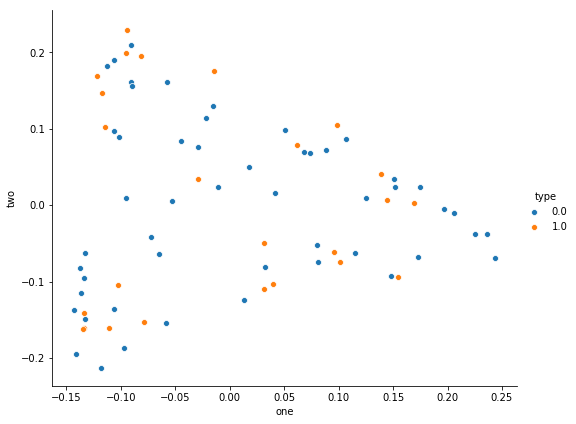

In [13]:
X_r, err = manifold.locally_linear_embedding(
    data.values, n_neighbors=6, n_components=2
)

ax=sns.pairplot(
    x_vars=["one"], 
    y_vars=["two"], 
    data=pd.DataFrame(np.hstack((X_r, behav["young_kid"].values[:, None])), columns=["one", "two", "type"]), 
    hue="type",
    height=6, aspect=10/8.27
)


## quick first pass to see what the accuracy is - using all the data & overfitting

In [14]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [15]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("lg", linear_model.LogisticRegression())
])

clf.fit(data.values, behav.young_kid.values)

print("overfitting, all data classification score: {} % correct".format(
    round(roc_auc_score(behav.young_kid.values, clf.predict(data.values))*100, 3)
))

overfitting, all data classification score: 80.039 % correct


## now overfitting using l1 regularization

In [16]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("lg", linear_model.LogisticRegression(
        penalty="l1",
        solver="liblinear"
    ))
])

clf.fit(data.values, behav.young_kid.values)

print("overfitting, all data classification score: {} % correct\n".format(
    round(roc_auc_score(behav.young_kid.values, clf.predict(data.values))*100, 3)
))

print("columns selected:")
for idx, col in enumerate(data.columns.values[(clf.named_steps["lg"].coef_ != 0).ravel()]):
    print(idx+1, col)

overfitting, all data classification score: 78.039 % correct

columns selected:
1 ctx_lh_G_temp_sup-G_T_transv.nii.gz
2 Left-Accumbens-area.nii.gz
3 ctx_rh_G_oc-temp_med-Parahip.nii.gz
4 Right-Accumbens-area.nii.gz
5 ctx_rh_G_temp_sup-Lateral.nii.gz
6 Left-Putamen.nii.gz
7 ctx_lh_S_collat_transv_ant.nii.gz
8 ctx_lh_Lat_Fis-post.nii.gz
9 ctx_lh_G_temp_sup-Plan_polar.nii.gz
10 ctx_rh_G_and_S_cingul-Ant.nii.gz
11 ctx_rh_S_temporal_sup.nii.gz
12 ctx_rh_Lat_Fis-post.nii.gz
13 Right-Amygdala.nii.gz
14 ctx_rh_G_postcentral.nii.gz
15 Left-Thalamus-Proper.nii.gz
16 ctx_rh_G_front_middle.nii.gz
17 ctx_lh_G_temporal_inf.nii.gz
18 ctx_rh_S_collat_transv_ant.nii.gz
19 ctx_rh_G_temporal_inf.nii.gz
20 ctx_rh_G_front_inf-Orbital.nii.gz
21 ctx_rh_G_precentral.nii.gz
22 ctx_rh_S_pericallosal.nii.gz
23 Left-Caudate.nii.gz
24 ctx_rh_S_front_middle.nii.gz
25 ctx_rh_S_oc-temp_med_and_Lingual.nii.gz
26 Right-Hippocampus.nii.gz
27 ctx_rh_G_temp_sup-G_T_transv.nii.gz
28 ctx_lh_S_suborbital.nii.gz


## rationale for why chance is not 50% for unbalanced classes, though I think ROC gets over this problem

chance level is the probability of a random classifier picking the majority class, here this is $y = 1 = {51\over{76}} \approx 0.67$: 

$$P(chance) = P(\hat y = 1)P(y = 1) + P(\hat y = 0) + P(y = 0)$$

according to this dataset: 

$$P(y = 1) \approx 0.671$$
$$P(y = 0) \approx 0.3289$$

so: 

$$P(\hat y = 1)P(y = 1) + P(\hat y = 0) + P(y = 0)$$

$$\approx 0.67 \times 0.67 + 0.33 \times 0.33$$
$$\approx 0.557$$

## in a day or two i'll add the proper analysis